## Individual-Based SZR Model

This individual-based SZR model takes into account the position of the individuals in the x,y space.
Each individual has a position that can change over time and belongs to a class (susceptible, zombie or removed). At each time step, 
- Each removed individual can resurrect. The time it takes to resurrect is exponentially distributed (with rate parameter $\zeta$)  or, more realistically, has a beta distribution with parameters proportional to $\zeta$

- Each susceptible, if there is at least one zombie in his neighborhood (given a radius), starts a fight with the nearest zombie. During the fight, or the susceptible becomes a zombie, or the zombie becomes a removed with probability respectively $\beta \over {(\alpha+\beta)}$ and $\alpha \over {(\alpha+\beta)}$ 

- each individual (except the removed ones) updates its location walking a random distance with its speed and on its direction (that are randomly set at the initialization) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import imageio
import seaborn as sns

In [2]:
def distance(coord_1,coord_2):
    """
    Calculate the distance between 2 individuals (with coords coord_1 and coord_2)
    """
    return np.sqrt((coord_1[0]-coord_2[0])**2 + (coord_1[1]-coord_2[1])**2)

class individual:
    """
    Each individual is instatiated with a location,
    a status and a set of boundaries
    
    The status is: 0->S, 1->Z, 2->R
    """
    def __init__(self,coords,status,bounds,speed):
        self.coord = coords
        self.status = status
        self.bounds = bounds
        self.speed = speed
        self.time_resurrection = 0
        self.time = 0

    
    def set_direction(self):
        """
        Set the direction during the initialization of the individual
        """
        angle = np.random.uniform(0,2*np.pi)
        x_direction = np.cos(angle)
        y_direction = np.sin(angle)

        self.x_direction = x_direction
        self.y_direction = y_direction
        

    def update_location(self):
        """
        At each time step, each individual updates its location 
        """
        speed = self.speed
        bounds = self.bounds
        distance = speed*np.random.random()
        
        #What to do if they run up against the boundary of the region
        if self.coord[0] + distance*self.x_direction < 0:
            new_x = -distance*self.x_direction-self.coord[0]
            self.x_direction = -self.x_direction
        elif self.coord[0] + distance*self.x_direction > bounds[0]:
            new_x = 2*bounds[0]-distance*self.x_direction - self.coord[0]
            self.x_direction = -self.x_direction
        else:
            new_x = self.coord[0] + distance*self.x_direction

        if self.coord[1] + distance*self.y_direction < 0:
            new_y = -distance*self.y_direction-self.coord[1]
            self.y_direction = -self.y_direction
        elif self.coord[1] + distance*self.y_direction > bounds[1]:
            new_y = 2*bounds[1]-distance*self.y_direction - self.coord[1]
            self.y_direction = -self.y_direction
        else:
            new_y = self.coord[1] + distance*self.y_direction

        self.coord = (new_x,new_y)
    

    def transmission(self,others,radius, dist, alpha = 0.4, beta = 0.6, zeta=0.2, kappa = 1, theta = 1):
        """
        At each time step, each individual:
         - if belongs to susceptible class -> it can be infected, if there is a zombie in its radius (param: beta)
         - if belongs to zombie class -> it can be killed, if there is a susceptible in its radius (param: alpha)
         - if belongs to removed class -> it can resurrect (param: zeta)
        """
        #if the status is removed, after some time it can resurrect:
        if self.status == 2:
            if(self.time_resurrection == 0):
                
                #the time it takes to resurrect is exponential or, more realistically, a beta distribution               
                if dist == 'gamma_dist':
                    self.time_resurrection = np.random.gamma(kappa, theta, 1)
                else:
                    self.time_resurrection = np.random.exponential(scale = 1/zeta, size = 1)
                
                self.time += 1
            elif(self.time > self.time_resurrection):
                self.status=1
                self.time = 0
                self.time_resurrection = 0
            else:
                self.time += 1
                
        #if the status is susceptible and there is a zombie in the neighbourhood, there is a fight:
        #we approximate that in this case
        #or the susceptible becomes a zombie, or the zombie becomes a removed
        elif self.status == 0:
            nearest_zombie = self
            nearest_distance = radius
            for other in others:
                if other.status == 1:
                    d = distance(self.coord,other.coord)
                    if (d < radius) & (d < nearest_distance):
                        nearest_zombie = other 
                            
            if nearest_zombie != self:
                reaction = np.random.choice(2, 1, p=[beta/(alpha+beta), alpha/(alpha+beta)])
                if reaction == 1:
                    nearest_zombie.status = 2
                else:
                    self.status = 1

In [3]:
def simulate(n_pop, alpha, beta, zeta, time, colors, classes, dist = 'gamma_dist', kappa=1, theta=1, ani = False):
    """
    Input: the number of individuals, the parameters of the model, the number of time steps, 
    the palette for the plots, the classes names and the distribution of the time it takes to resurrect
    (possible values: 'gamma_dist', 'exp_dist')
    Output: the GIF of the simulation and the plot of the trajectiories of the states of the population
    
    """
    bounds = (5,5)
    radius = .05
    
    #initialize the individuals
    everyone = []
    for n in range(int(n_pop*0.1)):
        everyone.append(individual((10*np.random.random(),10*np.random.random()),
                                   1,bounds,np.random.random()/25))

    for n in range(int(n_pop*0.9)):
        everyone.append(individual((10*np.random.random(),10*np.random.random()),
                                   0,bounds,np.random.random()/25))

    for n in range(0,len(everyone)):
        everyone[n].set_direction()
    if ani:
        #properties of the GIF   
        fig = plt.figure(figsize=(5,5))
        plt.style.use("dark_background")
        ax=plt.axes()
        plt.style.use("dark_background")
        plt.xlim(0,5)
        plt.ylim(0,5)
        plt.title('Animation of the SZR model')
        plt.xlabel('x')
        plt.ylabel('y')
        ims=[]
    
    status_hist = []
    
    #start the simulation
    for n in range(time):
        coords = []
        status = []
        for person in everyone:
            coords.append(person.coord)
            status.append(person.status)
        
        #initialize the states of the population
        counts = []
        counts.append(status.count(0))
        counts.append(status.count(1))
        counts.append(status.count(2))
        status_hist.append(counts)
        
        status = np.array(status)
        coords = np.array(coords)
        
        if ani:
            #"take a picture" of the system
            im=[ax.scatter(coords[:,0],coords[:,1],c=colors[status], label = classes[status])]
            plt.style.use("dark_background")

            ims.append(im)
        
        #Check for transmission and update everyone's location
        for i in range(0,len(everyone)):
            everyone[i].transmission(everyone[:i]+everyone[i+1:],radius, dist, alpha = alpha, beta = beta , zeta = zeta, kappa=kappa, theta=theta)
        for i in range(0,len(everyone)):
            if(everyone[i].status != 2):
                everyone[i].update_location()
    
    if ani:
    #create the animation
        ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,repeat_delay=10000)
        ani.save('./movie.gif', writer='pillow')
        plt.show(ani)
    
    #plot the trajectiories of the states of the population
    status_hist = np.array(status_hist)
    plt.style.use("dark_background")
    plt.plot(status_hist[: ,0], color = colors[0], label = 'susceptible')
    plt.plot(status_hist[: ,1], color = colors[1], label = 'zombie')
    plt.plot(status_hist[: ,2], color = colors[2], label = 'removed')
    plt.suptitle('Individual-based approach for the SZR model')
    plt.title('with n = {0:d} individuals'.format(n_pop), fontsize = 10)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('# individuals')
    plt.show()
    


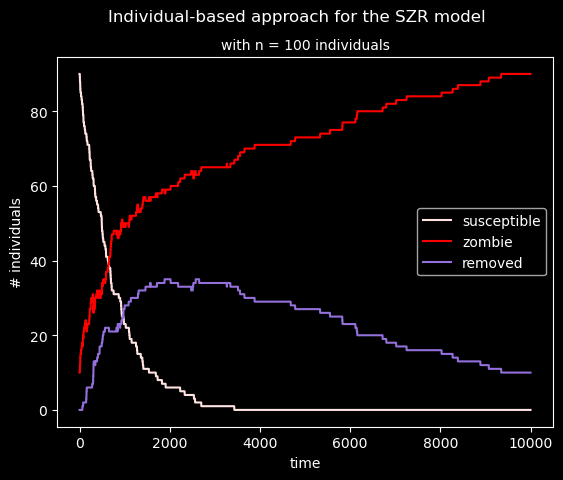

In [4]:
n_pop = 100
#alpha = 9.5
#beta = 5
#zeta = 9

alpha = 0.005
beta = 0.0095
zeta = 0.0001
time = 10000
colors = np.array(['mistyrose','red', 'mediumpurple']) #palette
classes = np.array(['susceptible','zombie','removed'])


dist = 'exp_dist'
simulate(n_pop, alpha, beta, zeta, time, colors, classes, dist, ani = False)

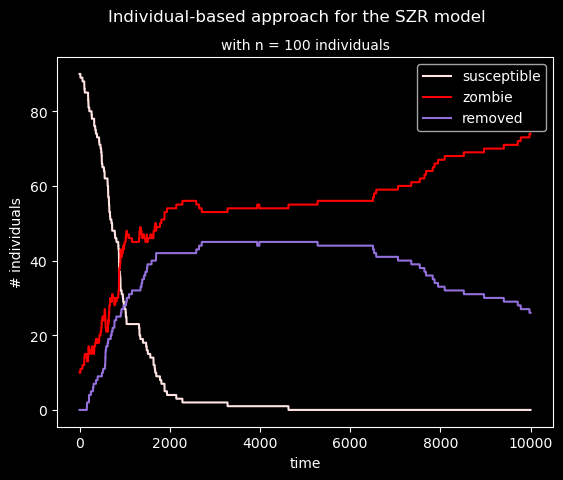

In [5]:
dist = 'gamma_dist' 
zeta = 0.0001
theta = 1000 
kappa = 1/(zeta*theta)

simulate(n_pop, alpha, beta, zeta, time, colors, classes, dist, kappa, theta)

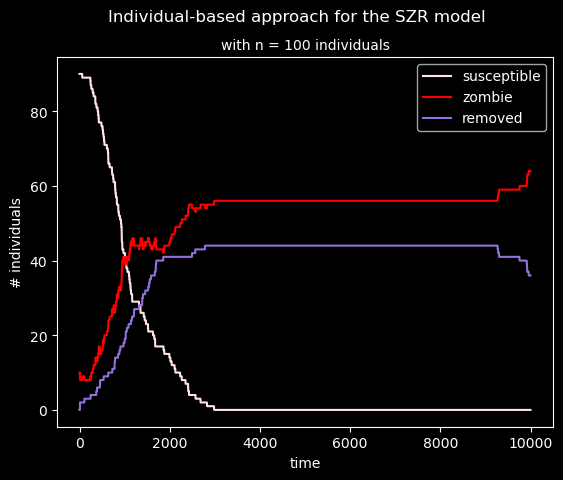

In [6]:
dist = 'gamma_dist' 
zeta = 0.0001
theta = 100
kappa = 1/(zeta*theta)

simulate(n_pop, alpha, beta, zeta, time, colors, classes, dist, kappa, theta)

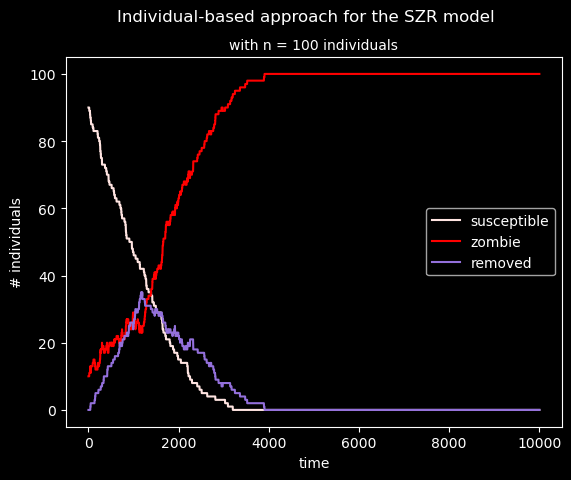

In [7]:
dist = 'gamma_dist' 
zeta= 0.001
theta = 50
kappa = 1/(zeta*theta)

simulate(n_pop, alpha, beta, zeta, time, colors, classes, dist, kappa, theta)

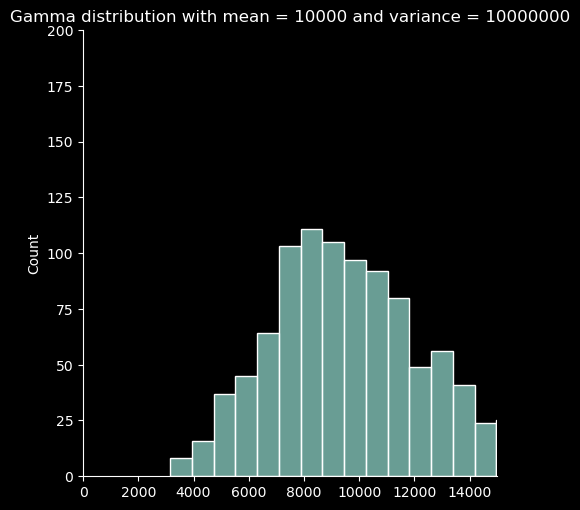

In [8]:
#check the distribution of the time it takes to resurrect:
zeta = 0.0001
theta = 1000
kappa = 1/(zeta*theta)

sns.displot(np.random.gamma(kappa, theta, 1000), kind = 'hist').set(title='Gamma distribution with mean = {0:d} and variance = {1:d}'.format(int(theta*kappa), int(kappa*theta**2)), xlim=(0,15000), ylim=(0,200))

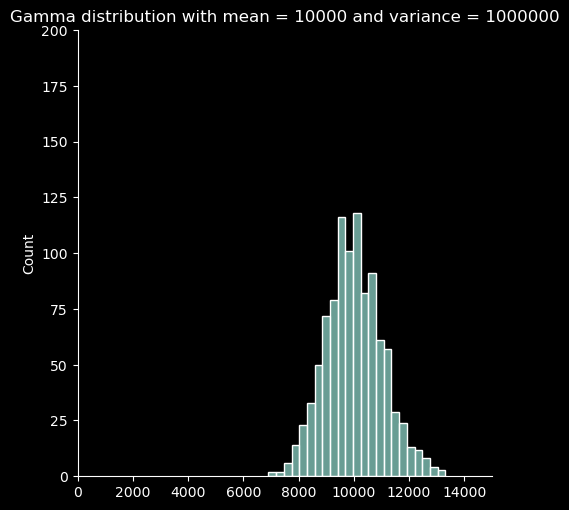

In [9]:
theta = 100
kappa = 1/(zeta*theta)
sns.displot(np.random.gamma(kappa, theta, 1000), kind = 'hist').set(title='Gamma distribution with mean = {0:d} and variance = {1:d}'.format(int(theta*kappa), int(kappa*theta**2)), xlim=(0,15000), ylim=(0,200))

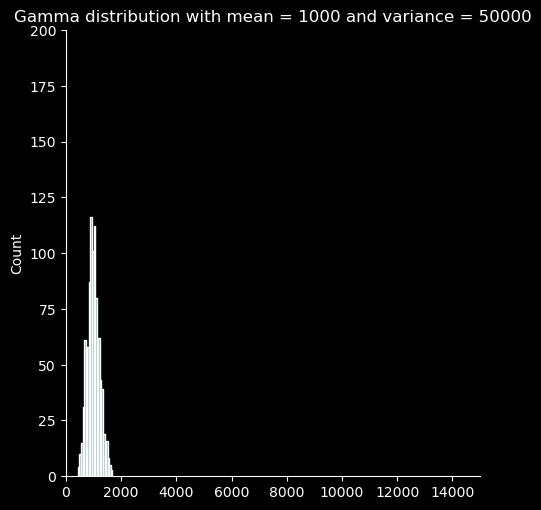

In [10]:
zeta= 0.001
theta = 50
kappa = 1/(zeta*theta)
sns.displot(np.random.gamma(kappa, theta, 1000), kind = 'hist').set(title='Gamma distribution with mean = {0:d} and variance = {1:d}'.format(int(theta*kappa), int(kappa*theta**2)), xlim=(0,15000), ylim=(0,200))

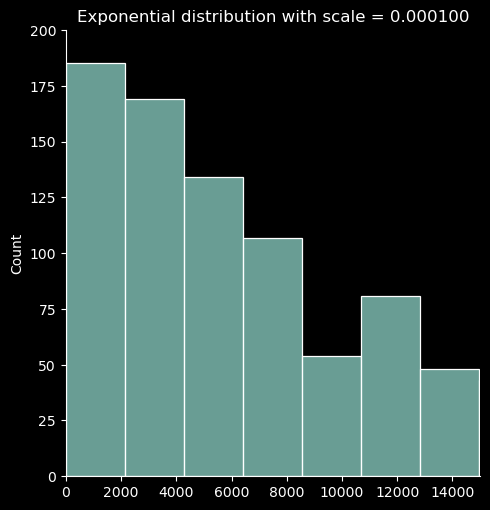

In [11]:
zeta = 0.0001
sns.displot(np.random.exponential(scale = 1/zeta, size = 1000), kind = 'hist').set(title='Exponential distribution with scale = {0:f}'.format(zeta), xlim=(0,15000), ylim=(0,200))